In [1]:
# Importing all required libraries

import numpy as np
from keras.datasets import mnist
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# Creating tensorflow and keras session

# A session is create cause it allocates resources and holds the actual values of intermediate results and variables.

# Keras acts as an interface for the TensorFlow library.

session = tf.Session()
keras.backend.set_session(session)

Using TensorFlow backend.
C:\Users\hp\anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hp\anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hp\anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hp\anaconda3\envs\tensorflow2

In [2]:
# MNIST is a dataset for black and white handwritten digits. This dataset is particularly simple, as we will see, neural
# networks can achieve very high levels of test accuracy.

# Each image is 28 x 28, for a size of 784 for each input.

# Splitting dataset into training and testing

(mn_x_train, mn_y_train), (mn_x_test, mn_y_test) = mnist.load_data()

In [3]:
# Printing sizes

print ("Training Examples: %d" % len(mn_x_train))
print ("Test Examples: %d" % len(mn_x_test))

Training Examples: 60000
Test Examples: 10000


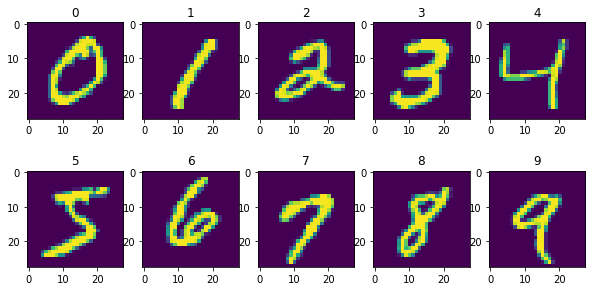

In [4]:
n_classes = 10 # Number of class labels (from 0 to 9)
inds=np.array([mn_y_train==i for i in range(n_classes)]) # creating numpy array of indexes for all 10 class labels
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten() # image flattening
for i in range(n_classes):
    ax[i].imshow(mn_x_train[np.argmax(inds[i])].reshape(28,28))
    ax[i].set_title(str(i))
plt.show()

# Neural Network Training

Keras is a high level library which can be used to train neural network models. It simplies coding neural networks for the datasets, and as installed, uses tensorflow for the backend. We use Keras for its simplicity and because these models can easily be linked into the cleverhans library to generate adversarial examples.

In [7]:
# Sequential model is a linear stack of layers.

from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])





Instructions for updating:
keep_dims is deprecated, use keepdims instead



The data must be pre-processed before analysis. We flatten the image and normalize the images so pixel values are between 0 and 1 instead of 0 and 255. The labels must also be inputted as one hot vectors, so we use built in keras functions.

In [8]:
train_images_1d = mn_x_train.reshape((60000, 28 * 28))
train_images_1d = train_images_1d.astype('float32') / 255

test_images_1d = mn_x_test.reshape((10000, 28 * 28))
test_images_1d = test_images_1d.astype('float32') / 255

In [9]:
from keras.utils import to_categorical #this just converts the labels to one-hot class
train_labels = to_categorical(mn_y_train)
test_labels = to_categorical(mn_y_test)

Training the network does not take long and can easily be done quickly on a CPU. Validation accuracy quickly rises to about 99%.

In [12]:
from keras.callbacks import ModelCheckpoint

h=network.fit(train_images_1d, 
              train_labels, 
              epochs=5, 
              batch_size=128, 
              shuffle=True, 
              callbacks=[ModelCheckpoint('tutorial_MNIST.h5',save_best_only=True)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/5
60000/60000 [==============================] - 6s - loss: 0.2551 - acc: 0.9254     
Epoch 2/5
 1792/60000 [..............................] - ETA: 6s - loss: 0.1245 - acc: 0.9581

C:\Users\hp\anaconda3\envs\tensorflow2\lib\site-packages\keras\callbacks.py:388: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


60000/60000 [==============================] - 6s - loss: 0.1035 - acc: 0.9694     - ETA: 0s - loss: 0.105
Epoch 3/5
60000/60000 [==============================] - 6s - loss: 0.0681 - acc: 0.9798     
Epoch 4/5
60000/60000 [==============================] - 7s - loss: 0.0495 - acc: 0.9846     
Epoch 5/5
60000/60000 [==============================] - 6s - loss: 0.0364 - acc: 0.9894     


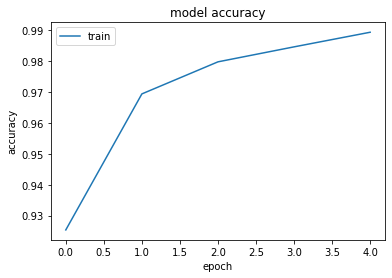

In [13]:
# summarize history for accuracy
plt.plot(h.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
score, acc = network.evaluate(test_images_1d, 
                            test_labels,
                            batch_size=128)

print ("Test Accuracy: %.5f" % acc)

 9728/10000 [============================>.] - ETA: 0sTest Accuracy: 0.98190


In [15]:
network.save('tutorial_MNIST.h5')

# Cleverhans Integration

Cleverhans is a library written by researchers on adversarial examples, many of whom are with Google Brain. The library has wrappers that allow us to take the Keras model that we just made (or an already trained model) and create adversarial examples.

If the model has already been created and we do not want to recreate it, just run the code below to reload the model.

In [16]:
from keras.models import load_model
network = load_model('tutorial_MNIST.h5')

In [17]:
from cleverhans.utils_keras import KerasModelWrapper
wrap = KerasModelWrapper(network)

In [18]:
x = tf.placeholder(tf.float32, shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))

results = np.zeros((10, 10000))
perturbations = np.zeros((10, 10000))
grid_shape = (10, 10, 28, 28, 1)
grid_data = np.zeros(grid_shape)


from cleverhans.attacks import SaliencyMapMethod
jsma = SaliencyMapMethod(wrap, sess=session)

jsma_params = {'theta': 1., 
               'gamma': 0.1,
               'clip_min': 0., 
               'clip_max': 1.,
               'y_target': None}

In [19]:
from cleverhans.utils import other_classes, grid_visual

for index in range(int(len(mn_x_test) / 100)):
    sample = test_images_1d[index: index + 1]
    current = mn_y_test[index]
    target_classes = other_classes(10, current)
    grid_data[current, current, :, :, :] = np.reshape(
            sample, (28, 28, 1))
    
    for target in target_classes:
        one_hot_target = np.zeros((1, 10))
        one_hot_target[0, target] = 1
        jsma_params['y_target'] = one_hot_target
        adv_x = jsma.generate_np(sample, **jsma_params)
        
        grid_data[target, current, :, :, :] = np.reshape(
                adv_x, (28, 28, 1))
        
    if index % 10 == 0:
        print(index)
        print(sample.shape)
        print(one_hot_target)
        print(adv_x.shape)

[INFO 2021-11-20 16:23:39,541 cleverhans] Constructing new graph for attack SaliencyMapMethod
C:\Users\hp\anaconda3\envs\tensorflow2\lib\site-packages\cleverhans\attacks_tf.py:356: UserWarning: Downcasting labels---this should be harmless unless they are smoothed
  warnings.warn("Downcasting labels---this should be harmless unless"


0
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
10
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
20
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(1, 784)
30
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
40
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
50
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
60
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
70
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
80
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)
90
(1, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(1, 784)


C:\Users\hp\anaconda3\envs\tensorflow2\lib\site-packages\cleverhans\utils.py:173: UserWarning: `grid_visual` has moved to `cleverhans.plot.pyplot_image`. cleverhans.utils.grid_visual may be removed on or after 2019-04-24.
  warnings.warn("`grid_visual` has moved to `cleverhans.plot.pyplot_image`. "
C:\Users\hp\anaconda3\envs\tensorflow2\lib\site-packages\cleverhans\plot\pyplot_image.py:63: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  figure.canvas.set_window_title('Cleverhans: Grid Visualization')


<Figure size 5760x5760 with 0 Axes>

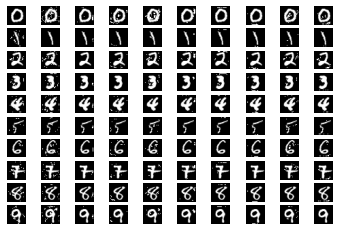

In [20]:
plt.figure(figsize = (80, 80))
_ = grid_visual(grid_data)